In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

### Load Data

Dataset: Numenta Anomaly Benchmark(NAB)
Description: It provides artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics.

We will use the 'art_daily_small_noise.csv' file for training and the 'art_daily_jumpsup.csv' file for testing.

https://www.kaggle.com/datasets/boltzmannbrain/nab

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix

df_small_noise = pd.read_csv(df_small_noise_url, parse_dates=True, index_col="timestamp")

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix

df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url, parse_dates=True, index_col="timestamp")

In [3]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


### Visualize the Data

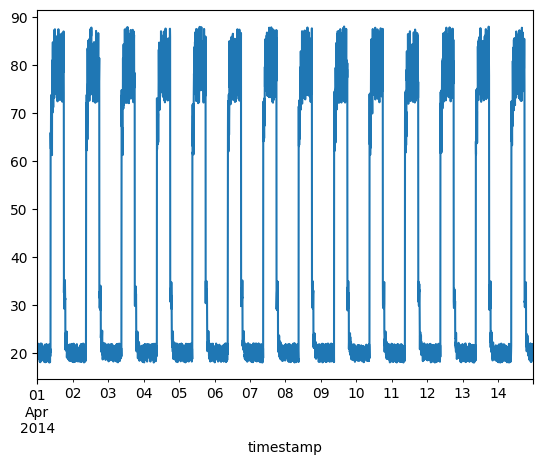

In [4]:
# Timeseries without anomaly data
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

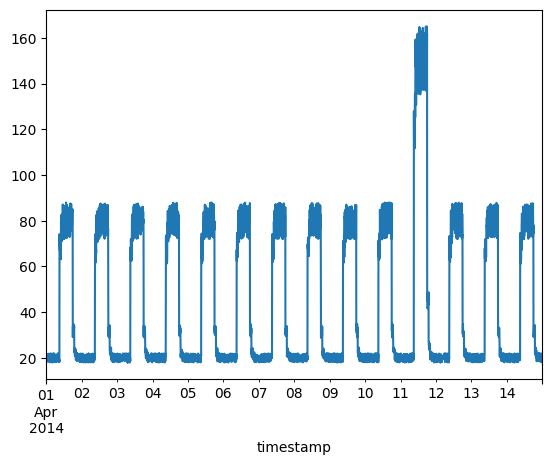

In [5]:
# Timeseries with anomaly data
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

### Prepare Training Data

We have a value for every 5 mins for 14 days.

24 * 60 / 5 = 288 timesteps per day

288 * 14 = 4032 data points in total

In [6]:
TIME_STEPS = 288

In [7]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()

df_training_value = (df_small_noise - training_mean) / training_std  # Standard normal distribution formula

print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


### Create Sequences



In [8]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):    # 0 to (4032 - 288 + 1) => 0 to 3745
        output.append(values[i : (i + time_steps)])  # (0 to 288), (1 to 289), (2 to 290)... (3744 to 4032) => Totally (3745, 288)
    return np.stack(output)   # (3745, 288, 1)

x_train = create_sequences(df_training_value.values) # len(df_training_value.values): 4032
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


### Build the model

The model will take input of shape (**batch_size**, **sequence_length**, **num_features**) and return output of the same shape. In this case, sequence_length is 288 and num_features is 1.

In [9]:
model = keras.Sequential(
    [
        # Encoder Block
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),

        # Decoder Block
        layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

### Train the Model

In [10]:
history = model.fit(x_train, x_train, epochs=50, batch_size=128,
    validation_split=0.1,
    callbacks=
    [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 5s 109ms/step - loss: 0.5160 - val_loss: 0.0607
Epoch 2/50
27/27 [==============================] - 3s 94ms/step - loss: 0.0774 - val_loss: 0.0380
Epoch 3/50
27/27 [==============================] - 2s 91ms/step - loss: 0.0558 - val_loss: 0.0316
Epoch 4/50
27/27 [==============================] - 4s 134ms/step - loss: 0.0464 - val_loss: 0.0278
Epoch 5/50
27/27 [==============================] - 3s 105ms/step - loss: 0.0403 - val_loss: 0.0258
Epoch 6/50
27/27 [==============================] - 2s 83ms/step - loss: 0.0359 - val_loss: 0.0247
Epoch 7/50
27/27 [==============================] - 4s 142ms/step - loss: 0.0325 - val_loss: 0.0259
Epoch 8/50
27/27 [==============================] - 6s 215ms/step - loss: 0.0300 - val_loss: 0.0242
Epoch 9/50
27/27 [==============================] - 5s 205ms/step - loss: 0.0278 - val_loss: 0.0250
Epoch 10/50
27/27 [==============================] - 7s 278ms/step - loss: 0.0259 - val_loss: 0.0241
Ep

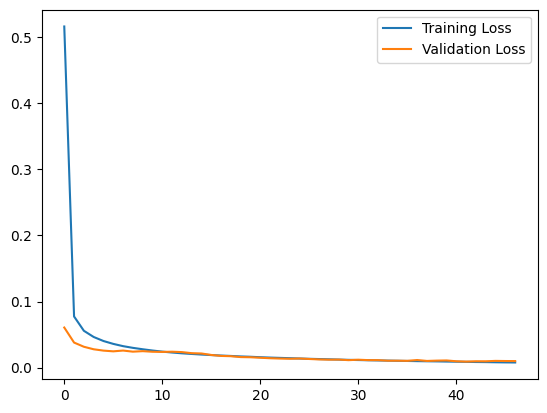

In [11]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

### Detecting Anomalies

* Find MAE loss on training samples.
* Find **max MAE loss value**. This is the worst our model has performed trying to reconstruct a sample. We will make this the **threshold** for anomaly detection.
* If the reconstruction loss for a sample is **greater than** this **threshold** value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an **anomaly**.

118/118 [==============================] - 2s 10ms/step


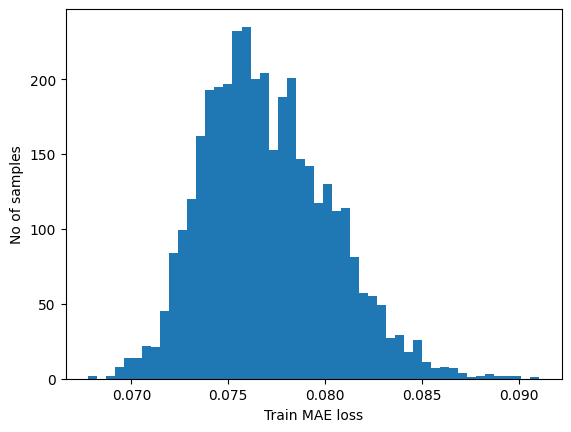

Reconstruction error threshold:  0.0910359758175942


In [12]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare Reconstruction

Let's see how our model has recontructed the first sample. This is the 288 timesteps from day 1 of our training dataset.

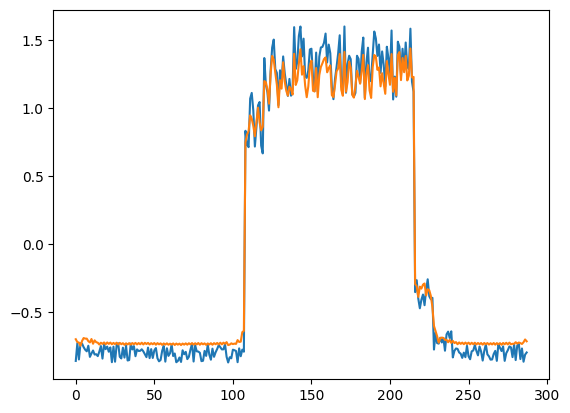

In [15]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])   # Smooth one is the predicted one
plt.show()

### Prepare Test Data

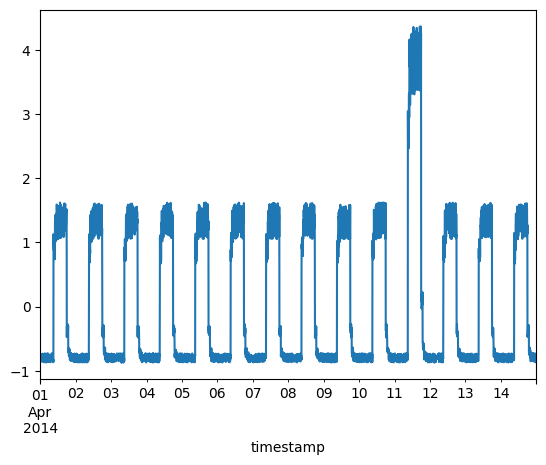

In [16]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std  # Why were the mean and standard deviation of the training data used?
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

### Create Sequences from Test Data


In [17]:
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


### Test Data MAE Loss

In [26]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss

118/118 [==============================] - 1s 9ms/step


array([[0.07851777],
       [0.07703937],
       [0.0785283 ],
       ...,
       [0.08038285],
       [0.07793124],
       [0.0806528 ]])

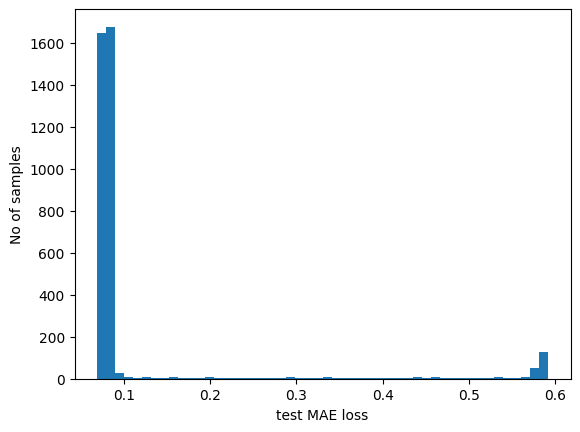

In [27]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [28]:
test_mae_loss = test_mae_loss.reshape((-1))
test_mae_loss

array([0.07851777, 0.07703937, 0.0785283 , ..., 0.08038285, 0.07793124,
       0.0806528 ])

### Detect all the samples which are anomalies

In [29]:
anomalies = test_mae_loss > threshold

print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  412
Indices of anomaly samples:  (array([ 790,  791,  793,  794, 1654, 1657, 1943, 1945, 2518, 2519, 2701,
       2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712,
       2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723,
       2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734,
       2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745,
       2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756,
       2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767,
       2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778,
       2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789,
       2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800,
       2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811,
       2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822,
       2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2

### Plot Anomalies

We will find the corresponding timestamps from the original test data. We will be using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our x_train will look like this:

0, 1, 2

1, 2, 3

2, 3, 4

3, 4, 5

4, 5, 6

5, 6, 7

6, 7, 8

7, 8, 9


All except the initial and the final time_steps-1 data values, will appear in time_steps number of samples. So, if we know that the samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point 5 is an anomaly.

In [32]:
# Data i is an anomaly if samples [(i - timestamps + 1)] are anomalies

anomalous_data_indices = []
for data_idx in range(TIME_STEPS -1, len(df_test_value) - TIME_STEPS + 1):   # (288-1) to (4032 - 288 + 1) => 287 to 3745
    # IF all values in one timestamp are anormal
    if np.all(anomalies[data_idx - TIME_STEPS + 1: data_idx]):   # (0 to 287), (1 to 288), (2 to 289), (3457 to 3744)
        anomalous_data_indices.append(data_idx)

### Plot test Data with Anomaly representation

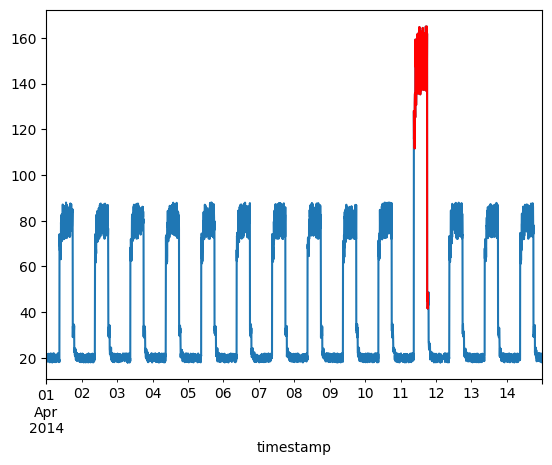

In [34]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color='r')
plt.show()

#### Reference

https://keras.io/examples/timeseries/timeseries_anomaly_detection/